<a href="https://colab.research.google.com/github/gcosma/DECODEclinicalTrialCalc/blob/main/STAGE2calculator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

| **Parameter**                        | **Value**                     | **Source**                                                                 | **Justification**                                                                                   |
|--------------------------------------|-------------------------------|---------------------------------------------------------------------------|-----------------------------------------------------------------------------------------------------|
| **Total LD Patients per Practice**   | 40                            | Static value                                                              | Based on the average LD patient population in primary care practices.                              |
| **MLTC Rate (%)**                    | 66.67                         | Static value                                                              | Expected proportion of LD patients with multiple long-term conditions.                             |
| **AHC Uptake Rate (%)**              | 70                            | Static value                                                              | Expected proportion of eligible patients who will receive Annual Health Checks.                    |
| **Expected Attrition Rate (%)**      | 20                            | Static value                                                              | Estimated proportion of participants who may drop out during the study.                            |
| **Study Recruitment Rate (%)**       | 40                            | Static value                                                              | Conservative estimate of eligible patients who will agree to participate in the study.             |
| **Practice Performance Variability (%)** | 35                        | Static value                                                              | Reflects variability in recruitment performance across practices (matches ICC of 0.05).            |
| **Minimum Practices per Arm**        | 18                            | Static value                                                              | Minimum number of practices required per study arm to ensure adequate recruitment.                 |

In [ ]:
# @title Step 1: Recruitment calculator
import ipywidgets as widgets
from IPython.display import display, clear_output, HTML
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

class EnhancedLDRecruitmentCalculator:
    def __init__(self):
        self.setup_controls()

    def setup_controls(self):
        style = {'description_width': '250px'}
        layout = widgets.Layout(width='500px')

        # Base recruitment parameters
        self.total_ld_patients_per_practice = widgets.IntText(
            value=40,
            description='Total LD Patients per Practice:',
            style=style,
            layout=layout
        )

        self.mltc_percentage = widgets.FloatText(
            value=66.67,
            description='MLTC Rate (%):',
            style=style,
            layout=layout
        )

        self.ahc_uptake_percentage = widgets.FloatText(
            value=70,
            description='AHC Uptake Rate (%):',
            style=style,
            layout=layout
        )

        # Attrition and response parameters
        self.attrition_rate = widgets.FloatText(
            value=20,
            description='Expected Attrition Rate (%):',
            style=style,
            layout=layout
        )

        self.study_recruitment_percentage = widgets.FloatText(
            value=40,
            description='Study Recruitment Rate (%):',
            style=style,
            layout=layout
        )

        # Practice variation parameters
        self.practice_performance_variability = widgets.FloatText(
            value=35, # Default value (matches your ICC of 0.05)
            description='Practice Performance Variability (%):',
            style=style,
            layout=layout
        )

        self.minimum_practices_per_arm = widgets.IntText(
            value=18,
            description='Minimum Practices per Arm:',
            style=style,
            layout=layout
        )

        # Fixed distributions for stratification
        self.severity_distribution = {
            'Mild': 40,
            'Moderate': 35,
            'Severe': 25
        }

        self.living_situation_distribution = {
            'Family': 60,
            'Independent': 25,
            'Supported': 15
        }

        # Recruitment rate modifiers
        self.severity_recruitment_modifiers = {
            'Mild': 1.2,
            'Moderate': 1.0,
            'Severe': 0.8
        }

        self.living_situation_modifiers = {
            'Family': 1.1,
            'Independent': 1.0,
            'Supported': 0.9
        }

        self.calc_button = widgets.Button(
            description='Calculate Recruitment',
            button_style='info',
            layout=widgets.Layout(width='200px')
        )
        self.calc_button.on_click(self.update_calculations)

    def display_controls(self):
        help_text = widgets.HTML("""
        <div style='background-color: #f8f9fa; padding: 15px; border-left: 5px solid #007bff; margin-bottom: 20px;'>
        <h4 style='margin-top: 0;'>Enhanced Recruitment Calculator Features:</h4>
        <ul>
            <li>Accounts for attrition in sample size calculations</li>
            <li>Models practice-level recruitment variation</li>
            <li>Includes stratification by LD severity and living situation</li>
            <li>Projects recruitment success probability</li>
        </ul>
        <p><strong>Target:</strong> 204 total participants (accounting for attrition)</p>
        </div>
        """)

        stratification_info = widgets.HTML(f"""
        <div style='background-color: #f8f9fa; padding: 15px; margin: 10px 0;'>
        <h4>Stratification Settings:</h4>
        <p><strong>LD Severity Distribution:</strong><br>
           Mild: {self.severity_distribution['Mild']}%<br>
           Moderate: {self.severity_distribution['Moderate']}%<br>
           Severe: {self.severity_distribution['Severe']}%</p>
        <p><strong>Living Situation Distribution:</strong><br>
           Family: {self.living_situation_distribution['Family']}%<br>
           Independent: {self.living_situation_distribution['Independent']}%<br>
           Supported: {self.living_situation_distribution['Supported']}%</p>
        </div>
        """)

        display(widgets.VBox([
            widgets.HTML("<h3>Enhanced LD Study Recruitment Calculator</h3>"),
            help_text,
            widgets.HTML("<h4>Base Parameters</h4>"),
            self.total_ld_patients_per_practice,
            self.mltc_percentage,
            self.ahc_uptake_percentage,
            widgets.HTML("<h4>Attrition and Response</h4>"),
            self.attrition_rate,
            self.study_recruitment_percentage,
            widgets.HTML("<h4>Practice Variation</h4>"),
            self.practice_performance_variability,
            self.minimum_practices_per_arm,
            widgets.HTML("<h4>Population Stratification</h4>"),
            stratification_info,
            widgets.HBox([self.calc_button],
                        layout=widgets.Layout(justify_content='center', padding='20px'))
        ], layout=widgets.Layout(padding='20px')))

    def calculate_stratified_recruitment(self):
        base_patients = self.total_ld_patients_per_practice.value
        mltc_rate = self.mltc_percentage.value / 100
        ahc_rate = self.ahc_uptake_percentage.value / 100
        recruitment_rate = self.study_recruitment_percentage.value / 100
        attrition_rate = self.attrition_rate.value / 100

        stratified_results = []

        for severity, severity_pct in self.severity_distribution.items():
            for living, living_pct in self.living_situation_distribution.items():
                # Calculate stratum size
                stratum_size = base_patients * (severity_pct/100) * (living_pct/100)

                # Apply recruitment modifiers
                adjusted_recruitment = (recruitment_rate *
                                     self.severity_recruitment_modifiers[severity] *
                                     self.living_situation_modifiers[living])

                # Calculate expected recruits
                eligible = stratum_size * mltc_rate * ahc_rate
                expected_recruits = eligible * adjusted_recruitment

                # Account for attrition
                final_recruits = expected_recruits * (1 - attrition_rate)

                stratified_results.append({
                    'severity': severity,
                    'living': living,
                    'stratum_size': stratum_size,
                    'eligible': eligible,
                    'expected_recruits': expected_recruits,
                    'final_recruits': final_recruits
                })

        return stratified_results

    def model_practice_variation(self, mean_recruits):
        variability = self.practice_performance_variability.value / 100
        min_practices = self.minimum_practices_per_arm.value

        # Prevent division by zero or near-zero mean
        safe_mean_recruits = max(mean_recruits, 1e-6)
        # Generate practice-level recruitment distribution
        practice_performances = np.random.normal(
            mean_recruits,
            mean_recruits * variability,
            size=1000
        )
        practice_performances = np.clip(practice_performances, 0, 3 * safe_mean_recruits)


        # Calculate probability of meeting recruitment target
        target_per_arm = 102  # Half of 204 total target
        simulated_totals = []

        for _ in range(1000):
            practices = np.random.choice(practice_performances, size=min_practices)
            total_recruits = sum(practices)
            simulated_totals.append(total_recruits)

        prob_success = sum(np.array(simulated_totals) >= target_per_arm) / 1000

        return {
            'mean_performance': np.mean(practice_performances),
            'performance_sd': np.std(practice_performances),
            'prob_success': prob_success,
            'simulated_totals': simulated_totals
        }

    def plot_recruitment_analysis(self, stratified_results, practice_variation):
        required_total_sample_size = 204
        number_of_practices = np.arange(24, 49, 2)
        total_per_practice = sum(r['final_recruits'] for r in stratified_results)

        # Calculate total projections
        avg_total = number_of_practices * total_per_practice
        percentage_above_target = ((avg_total - required_total_sample_size) / required_total_sample_size) * 100

        # Create figure with subplots
        fig = plt.figure(figsize=(15, 18))
        gs = plt.GridSpec(3, 1, height_ratios=[1.2, 1, 0.8], hspace=0.4)

        # Plot 1: Practice Number Analysis
        ax1 = fig.add_subplot(gs[0])
        colors = plt.cm.RdYlGn(np.linspace(0, 1, len(number_of_practices)))
        bars = ax1.bar(number_of_practices, percentage_above_target, color=colors)

        # Add variability ranges
        min_total = number_of_practices * np.percentile(practice_variation['simulated_totals'], 2.5)/self.minimum_practices_per_arm.value
        max_total = number_of_practices * np.percentile(practice_variation['simulated_totals'], 97.5)/self.minimum_practices_per_arm.value
        min_percentage = ((min_total - required_total_sample_size) / required_total_sample_size) * 100
        max_percentage = ((max_total - required_total_sample_size) / required_total_sample_size) * 100

        ax1.fill_between(number_of_practices,
                        min_percentage, max_percentage,
                        color='gray', alpha=0.2,
                        label='95% Confidence Interval')

        # Add target line and annotations
        ax1.axhline(y=0, color='black', linestyle='--', alpha=0.5, label='Target (204)')
        target_idx = np.where(number_of_practices == 36)[0][0]
        ax1.plot(36, percentage_above_target[target_idx], 'r*', markersize=15,
                label=f'Target: 36 practices\n({avg_total[target_idx]:.0f} participants)')

        # Add bar annotations
        for i, v in enumerate(percentage_above_target):
            ax1.text(number_of_practices[i], v + (1 if v >= 0 else -3),
                    f'{number_of_practices[i]} practices\n{avg_total[i]:.0f} participants\n{v:.1f}%',
                    ha='center', va='bottom', fontsize=8)

        ax1.set_xlabel('Number of Practices', fontsize=12, fontweight='bold')
        ax1.set_ylabel('Percentage Above Target (%)', fontsize=12, fontweight='bold')
        ax1.set_title('Expected Recruitment by Practice Numbers',
                     fontsize=14, pad=20, fontweight='bold')

        # Updated legend position to top left corner
        ax1.legend(loc='upper left', bbox_to_anchor=(0.02, 0.98),
                  fancybox=True, shadow=True, ncol=1)
        ax1.grid(True, alpha=0.3)




        # Plot 2: Stratification Heatmap
        ax2 = fig.add_subplot(gs[1])
        severities = list(self.severity_distribution.keys())
        living_situations = list(self.living_situation_distribution.keys())

        data = np.zeros((len(severities), len(living_situations)))
        for i, severity in enumerate(severities):
            for j, living in enumerate(living_situations):
                result = next(r for r in stratified_results
                            if r['severity'] == severity and r['living'] == living)
                data[i, j] = result['final_recruits']

        im = ax2.imshow(data, cmap='YlOrRd')
        ax2.set_xticks(range(len(living_situations)))
        ax2.set_yticks(range(len(severities)))
        ax2.set_xticklabels(living_situations)
        ax2.set_yticklabels(severities)
        plt.colorbar(im, ax=ax2)
        ax2.set_title('Expected Recruitment by Patient Characteristics\n(after attrition)')

        # Plot 3: Success Probability Distribution
        ax3 = fig.add_subplot(gs[2])
        ax3.hist(practice_variation['simulated_totals'], bins=30,
                color='skyblue', alpha=0.7)
        ax3.axvline(102, color='red', linestyle='--',
                   label='Target per arm (102)')
        ax3.set_title(f"Recruitment Success Probability Distribution\n"
                     f"Probability of Meeting Target: {practice_variation['prob_success']:.1%}")
        ax3.set_xlabel('Total Recruits per Arm')
        ax3.set_ylabel('Frequency')
        ax3.legend()

        plt.tight_layout()
        plt.show()

        # Print comprehensive analysis
        print("\n📊 Recruitment Analysis Summary")
        print("==============================")
        print(f"Total expected recruits per practice: {total_per_practice:.1f}")
        print(f"Required practices per arm: {np.ceil(102/total_per_practice):.0f}")

        print("\n📈 Recruitment Success Analysis")
        print(f"• Probability of meeting target: {practice_variation['prob_success']:.1%}")
        print(f"• Expected variation range: {np.percentile(practice_variation['simulated_totals'], 2.5):.1f} to "
              f"{np.percentile(practice_variation['simulated_totals'], 97.5):.1f} participants")

        if practice_variation['prob_success'] < 0.8:
            additional_practices = np.ceil(102/(total_per_practice * 0.8))
            print(f"\n⚠️ Risk Mitigation Recommendation:")
            print(f"• Consider increasing to {additional_practices:.0f} practices per arm to ensure target recruitment")

    def update_calculations(self, _):
        clear_output(wait=True)
        self.display_controls()

        stratified_results = self.calculate_stratified_recruitment()
        total_per_practice = sum(r['final_recruits'] for r in stratified_results)
        practice_variation = self.model_practice_variation(total_per_practice)

        self.plot_recruitment_analysis(stratified_results, practice_variation)

# Create and display calculator
calculator = EnhancedLDRecruitmentCalculator()
calculator.display_controls()

#Step 2: Power and Sample size calculator

| **Category**               | **Parameter**                        | **Value**                     | **Source**                                                                 | **Justification**                                                                                   | **Affects Power Analysis?** |
|----------------------------|--------------------------------------|-------------------------------|---------------------------------------------------------------------------|-----------------------------------------------------------------------------------------------------|-----------------------------|
| **Study Design**           | **EQ-5D Version**                   | EQ-5D-3L                      | Static value                                                              | Standard version of EQ-5D used for health-related quality of life measurement.                     | N/A                          |
|                            | **Statistical Power**               | 0.9                           | Static value                                                              | Standard power level to ensure a 90% chance of detecting a true effect.                            | Yes                         |
|                            | **Significance Level (α)**          | 0.05                          | Static value                                                              | Standard threshold for statistical significance.                                                   | Yes                         |
|                            | **Intraclass Correlation Coefficient (ICC)** | 0.05                  | Static value                                                              | Reflects the degree of similarity among patients within the same practice.                         | Yes                         |
|                            | **Average Patients per Practice**   | 6                             | Static value                                                              | Expected number of recruited patients per practice after accounting for eligibility and uptake.     | Yes                         |
|                            | **Expected Dropout Rate**           | 0.2 (20%)                     | Static value                                                              | Estimated proportion of participants who may drop out during the study.                            | Yes                         |
|                            | **Baseline-Outcome Correlation**    | 0.5                           | Static value                                                              | Assumed correlation between baseline and follow-up EQ-5D scores.                                   | Yes                         |
| **Stratification**         | **Enable Stratification**           | Yes                           | Static value                                                              | Ensures balanced representation of patient subgroups in the study.                                 | No                          |
|                            | **LD Severity Distribution**        | Mild: 40%, Moderate: 35%, Severe: 25% | Static value                                                              | Proportion of LD patients by severity level.                                                       | No                          |
|                            | **Living Situation Distribution**   | Family: 60%, Independent: 25%, Supported: 15% | Static value                                                              | Proportion of LD patients by living situation.                                                     | No                          |
| **EQ-5D Parameters**       | **Baseline EQ-5D Score**            | 0.64                          | Static value                                                              | Expected baseline health-related quality of life score for the LD population.                      | No                          |
|                            | **EQ-5D Standard Deviation**        | 0.26                          | Static value                                                              | Reflects variability in EQ-5D scores among the LD population.                                      | Yes                         |
|                            | **Minimal Clinically Important Difference (MCID)** | 0.074          | Static value                                                              | Smallest change in EQ-5D score considered clinically meaningful.                                   | Yes                         |
| **Effect Size Analysis**   | **Analysis Type**                   | Single Effect Size            | Static value                                                              | Focuses on a single effect size for primary analysis.                                              | Yes                         |
|                            | **Effect Sizes to Analyze**         | 0.074, 0.10, 0.15, 0.20       | Static value                                                              | Range of effect sizes to evaluate sensitivity and robustness of findings.                          | Yes                         |

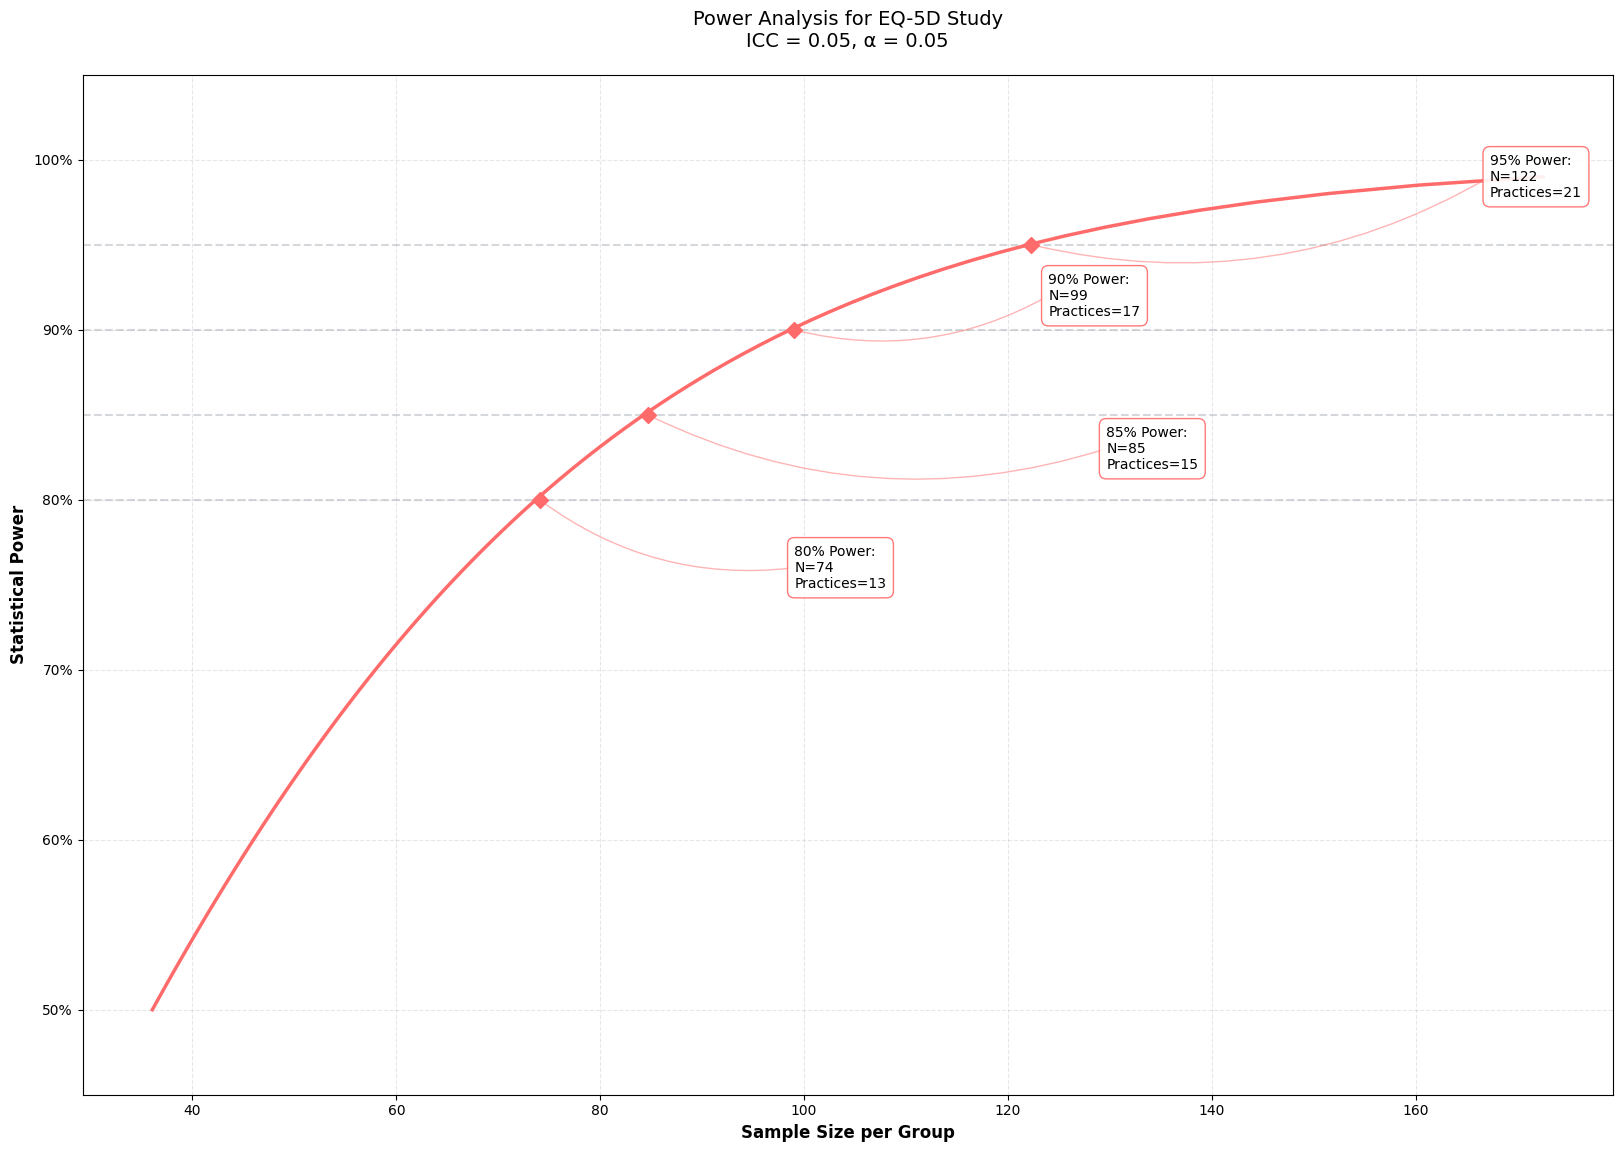


📊 Sample Size Analysis Summary

📋 Study Design Specifications:
• EQ-5D Version: EQ-5D-3L
• Statistical Power: 90.00%
• Significance Level (α): 0.050
• ICC: 0.050
• Cluster Size: 6
• Dropout Rate: 20%
• Baseline-Outcome Correlation: 0.50

🎯 Analysis for Effect Size 0.150:
• Effect Size / MCID Ratio: 2.0x

📈 Sample Size Calculations:
• Base sample size (unadjusted): 63
• Design effect: 1.25
• Final adjusted sample size per group: 99
• Total study size: 197
• Required practices per group: 17
• Total practices needed: 34

📊 Stratified Sample Sizes:
• Mild, Family:
  - 24.0% of sample
  - 24 participants per group
  - 47 total participants
• Mild, Independent:
  - 10.0% of sample
  - 10 participants per group
  - 20 total participants
• Mild, Supported:
  - 6.0% of sample
  - 6 participants per group
  - 12 total participants
• Moderate, Family:
  - 21.0% of sample
  - 21 participants per group
  - 41 total participants
• Moderate, Independent:
  - 8.8% of sample
  - 9 participants per gro

In [ ]:
# @title Step 2: Power and Sample size calculator
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as widgets
from IPython.display import clear_output, display, HTML
import pandas as pd

class EnhancedEQ5DAnalyzer:
    def __init__(self):
        # Initialize tooltips dictionary
        self.tooltips = {
            'eq5d_version': 'Selected 3L (simpler) for its suitability for the LD population',
            'power': 'Probability of detecting a true effect (typically 0.80-0.90)',
            'alpha': 'Probability of Type I error (typically 0.05)',
            'icc': 'Intraclass Correlation Coefficient for cluster adjustment',
            'baseline_correlation': 'Expected correlation between baseline and follow-up measurements',
            'mcid': 'Minimal Clinically Important Difference for EQ-5D'
        }

        # Set up controls after tooltips are initialized
        self.setup_controls()

    def setup_controls(self):
        """Initialize all UI controls with appropriate defaults"""
        style = {'description_width': '300px'}
        layout = widgets.Layout(width='400px')

        # EQ-5D Version Selection
        self.eq5d_version = widgets.Dropdown(
            options=['EQ-5D-3L'],
            value='EQ-5D-3L',
            description='EQ-5D Version:',
            style=style,
            layout=layout
        )

        # Study Parameters
        self.power = widgets.BoundedFloatText(
            value=0.90,
            min=0.5,
            max=0.99,
            description='Statistical Power:',
            style=style,
            layout=layout
        )

        self.alpha = widgets.BoundedFloatText(
            value=0.05,
            min=0.01,
            max=0.10,
            description='Significance Level (α):',
            style=style,
            layout=layout
        )

        self.icc = widgets.BoundedFloatText(
            value=0.05,
            min=0,
            max=1,
            description='Intraclass Correlation Coefficient:',
            style=style,
            layout=layout
        )

        self.cluster_size = widgets.BoundedIntText(
            value=6,
            min=1,
            max=50,
            description='Average Patients per Practice:',
            style=style,
            layout=layout
        )

        self.dropout_rate = widgets.BoundedFloatText(
            value=0.20,
            min=0,
            max=0.5,
            description='Expected Dropout Rate:',
            style=style,
            layout=layout
        )

        self.baseline_correlation = widgets.BoundedFloatText(
            value=0.5,
            min=0,
            max=1,
            description='Baseline-Outcome Correlation:',
            style=style,
            layout=layout
        )

        # Stratification Parameters
        self.enable_stratification = widgets.Checkbox(
            value=True,
            description='Enable Stratification',
            style=style,
            layout=layout
        )

        self.severity_distribution = widgets.Text(
            value='40,35,25',
            description='LD Severity Distribution (Mild,Mod,Severe %):',
            style=style,
            layout=layout
        )

        self.living_distribution = widgets.Text(
            value='60,25,15',
            description='Living Situation (Family,Indep,Support %):',
            style=style,
            layout=layout
        )

        # EQ-5D Parameters
        self.baseline_score = widgets.BoundedFloatText(
            value=0.64,
            min=-0.594,
            max=1,
            description='Baseline EQ-5D Score:',
            style=style,
            layout=layout
        )

        self.score_sd = widgets.BoundedFloatText(
            value=0.26,
            min=0,
            max=1,
            description='EQ-5D Standard Deviation:',
            style=style,
            layout=layout
        )

        self.mcid = widgets.BoundedFloatText(
            value=0.074,
            min=0,
            max=1,
            description='Minimal Clinically Important Difference:',
            style=style,
            layout=layout
        )

        # Effect Sizes
        self.effect_sizes = widgets.SelectMultiple(
            options=[0.04, 0.05, 0.06, 0.074, 0.10, 0.15, 0.20],
            value=[0.04, 0.05, 0.06, 0.074, 0.10, 0.15, 0.20],  # Select all effect sizes by default
            description='Effect Sizes to Analyze:',
            style=style,
            layout=layout
        )

        # Analysis Type
        self.analysis_type = widgets.RadioButtons(
            options=['Single Effect Size', 'Multiple Effect Sizes'],
            value='Multiple Effect Sizes',  # Set to Multiple Effect Sizes by default
            description='Analysis Type:',
            style={'description_width': 'initial'},
            layout=widgets.Layout(
                width='400px',
                margin='10px 0px 20px 0px',
                display='flex',
                flex_direction='column',
                row_gap='10px'
            )
        )

        # Calculate Button
        self.calc_button = widgets.Button(
            description='Calculate Sample Size',
            button_style='info',
            layout=widgets.Layout(width='200px')
        )
        self.calc_button.on_click(self.update_analysis)

    def calculate_base_sample_size(self, effect_size=None):
        """Calculate base sample size before adjustments"""
        if effect_size is None:
            effect_size = list(self.effect_sizes.value)[0]

        # Calculate z-scores for power and alpha
        z_alpha = stats.norm.ppf(1 - self.alpha.value/2)
        z_beta = stats.norm.ppf(self.power.value)

        # Adjust variance for baseline correlation
        variance_adjusted = 2 * self.score_sd.value**2 * (1 - self.baseline_correlation.value)

        # Calculate base sample size
        n = 2 * ((z_alpha + z_beta)**2 * variance_adjusted) / (effect_size**2)
        return n

    def calculate_adjusted_sample_size(self, base_n):
        """Apply clustering and dropout adjustments"""
        # Calculate design effect
        design_effect = 1 + ((self.cluster_size.value - 1) * self.icc.value)

        # Apply design effect and dropout adjustment
        n_adjusted = base_n * design_effect / (1 - self.dropout_rate.value)

        return n_adjusted

    def calculate_stratified_sample_sizes(self, total_n):
        """Calculate sample sizes for each stratum"""
        if not self.enable_stratification.value:
            return None

        try:
            severity_dist = [float(x)/100 for x in self.severity_distribution.value.split(',')]
            living_dist = [float(x)/100 for x in self.living_distribution.value.split(',')]

            if not (0.99 <= sum(severity_dist) <= 1.01 and 0.99 <= sum(living_dist) <= 1.01):
                raise ValueError("Distributions must sum to 100%")
        except:
            print("Error: Invalid distribution format. Please use comma-separated percentages.")
            return None

        strata = []
        for sev_pct in severity_dist:
            for liv_pct in living_dist:
                stratum_n = total_n * sev_pct * liv_pct
                strata.append({
                    'severity': ['Mild', 'Moderate', 'Severe'][severity_dist.index(sev_pct)],
                    'living': ['Family', 'Independent', 'Supported'][living_dist.index(liv_pct)],
                    'percentage': sev_pct * liv_pct * 100,
                    'n': stratum_n
                })

        return strata

    def plot_power_analysis(self):
          """Create power analysis visualization with improved layout for both single and multiple effect sizes"""
          # Adjust figure size based on analysis type
          if self.analysis_type.value == 'Single Effect Size':
              plt.figure(figsize=(15, 10))  # Smaller size for single effect
          else:
              plt.figure(figsize=(18, 12))  # Larger size for multiple effects

          colors = ['#FF6B6B', '#45B7D1', '#4ECDC4', '#96CEB4']

          if self.analysis_type.value == 'Single Effect Size':
              effect_sizes = [list(self.effect_sizes.value)[0]]
          else:
              effect_sizes = self.effect_sizes.value

          powers = np.linspace(0.5, 0.99, 100)

          # Adjust offsets based on analysis type
          if self.analysis_type.value == 'Single Effect Size':
              y_offsets = {0.80: -0.03, 0.85: -0.015, 0.90: 0.015, 0.95: 0.03}
              x_offsets = {0.80: 15, 0.85: 20, 0.90: 15, 0.95: 20}
          else:
              y_offsets = {0.80: -0.04, 0.85: -0.02, 0.90: 0.02, 0.95: 0.04}
              x_offsets = {0.80: 25, 0.85: 45, 0.90: 25, 0.95: 45}

          for i, effect_size in enumerate(effect_sizes):
              sample_sizes = []
              current_power = self.power.value

              for p in powers:
                  self.power.value = p
                  base_n = self.calculate_base_sample_size(effect_size)
                  adjusted_n = self.calculate_adjusted_sample_size(base_n)
                  sample_sizes.append(adjusted_n)

              self.power.value = current_power

              plt.plot(sample_sizes, powers,
                      label=f'Effect size {effect_size:.3f}',
                      color=colors[i % len(colors)],
                      linewidth=2.5)

              target_powers = [0.80, 0.85, 0.90, 0.95]

              for target_power in target_powers:
                  idx = np.abs(powers - target_power).argmin()
                  n = sample_sizes[idx]
                  practices = np.ceil(n / self.cluster_size.value)

                  plt.plot(n, target_power, 'D',
                          color=colors[i % len(colors)],
                          markersize=8)

                  y_pos = target_power + y_offsets[target_power]
                  x_pos = n + x_offsets[target_power]

                  bbox_props = dict(
                      boxstyle="round,pad=0.5",
                      fc="white",
                      ec=colors[i % len(colors)],
                      alpha=0.9,
                      mutation_scale=0.8
                  )

                  # Add connector line
                  plt.annotate('',
                      xy=(n, target_power),
                      xytext=(x_pos, y_pos),
                      arrowprops=dict(
                          arrowstyle='-',
                          color=colors[i % len(colors)],
                          alpha=0.5,
                          connectionstyle='arc3,rad=-0.2'
                      ))

                  # Add text annotation
                  plt.annotate(
                      f'{target_power:.0%} Power:\nN={n:,.0f}\nPractices={practices:.0f}',
                      xy=(x_pos, y_pos),
                      xytext=(0, 0),
                      textcoords='offset points',
                      bbox=bbox_props,
                      fontsize=10,
                      ha='left',
                      va='center'
                  )

          # Add reference lines
          for power in target_powers:
              plt.axhline(y=power,
                        color='#2c3e50',
                        linestyle='--',
                        alpha=0.2,
                        zorder=1)

          plt.xlabel('Sample Size per Group', fontsize=12, weight='bold')
          plt.ylabel('Statistical Power', fontsize=12, weight='bold')
          plt.title('Power Analysis for EQ-5D Study\n' +
                  f'ICC = {self.icc.value:.2f}, α = {self.alpha.value}',
                  fontsize=14,
                  pad=20)

          # Adjust legend based on analysis type
          if len(effect_sizes) > 1:
              legend = plt.legend(title='Effect Sizes',
                                bbox_to_anchor=(1.05, 1),
                                loc='upper left',
                                frameon=True,
                                fancybox=True,
                                shadow=True)
              legend.get_frame().set_alpha(0.9)
              plt.subplots_adjust(right=0.85, top=0.95, bottom=0.1, left=0.1)
          else:
              # For single effect size, use tighter margins
              plt.subplots_adjust(right=0.95, top=0.95, bottom=0.1, left=0.1)

          plt.grid(True, linestyle='--', alpha=0.3)
          plt.ylim(0.45, 1.05)  # Consistent y-axis limits

          plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))

          plt.show()

    def display_controls(self):
        """Display the calculator interface with all controls"""
        methodology_notes = widgets.HTML(
            "<div style='background-color: #f8f9fa; padding: 15px; margin: 10px 0; border-left: 5px solid #007bff;'>"
            "<h4>Methodology Notes:</h4>"
            "<ul>"
            f"<li><strong>EQ-5D Version Selection:</strong> {self.eq5d_version.value} chosen for its suitability for the LD population</li>"
            "<li><strong>Baseline Adjustment:</strong> Sample size adjusted for baseline-outcome correlation</li>"
            "<li><strong>Clustering:</strong> Design effect applied using ICC</li>"
            "<li><strong>Stratification:</strong> Accounts for LD severity and living situation</li>"
            "</ul>"
            "</div>"
        )

        warning_html = widgets.HTML(
            "<div style='background-color: #fff3cd; padding: 10px; margin: 10px 0; border-left: 5px solid #ffeeba;'>"
            "<strong>Important Considerations:</strong><br>"
            "• All calculations assume normally distributed outcomes<br>"
            "• Baseline measurements should align with randomization timing<br>"
            "• Effect sizes should be justified against MCID<br>"
            "• Cluster sizes are assumed to be approximately equal<br>"
            "• Dropout rates are assumed to be non-informative or missing completely at random (MCAR)."
            "</div>"
        )

        display(widgets.VBox([
            methodology_notes,
            warning_html,
            widgets.HTML("<h3>Study Design Parameters</h3>"),
            self.eq5d_version,
            self.power,
            self.alpha,
            self.icc,
            self.cluster_size,
            self.dropout_rate,
            self.baseline_correlation,
            widgets.HTML("<h3>Stratification Parameters</h3>"),
            self.enable_stratification,
            self.severity_distribution,
            self.living_distribution,
            widgets.HTML("<h3>EQ-5D Parameters</h3>"),
            self.baseline_score,
            self.score_sd,
            self.mcid,
            widgets.HTML("<h3>Effect Size Analysis</h3>"),
            widgets.VBox([
                self.analysis_type,
                self.effect_sizes
            ], layout=widgets.Layout(margin='10px 0px')),
            widgets.HBox([self.calc_button],
                        layout=widgets.Layout(justify_content='center', padding='20px'))
        ], layout=widgets.Layout(padding='20px')))

    def display_summary(self):
        """Display comprehensive analysis summary"""
        print("\n📊 Sample Size Analysis Summary")
        print("===============================")

        print("\n📋 Study Design Specifications:")
        print(f"• EQ-5D Version: {self.eq5d_version.value}")
        print(f"• Statistical Power: {self.power.value:.2%}")
        print(f"• Significance Level (α): {self.alpha.value:.3f}")
        print(f"• ICC: {self.icc.value:.3f}")
        print(f"• Cluster Size: {self.cluster_size.value}")
        print(f"• Dropout Rate: {self.dropout_rate.value:.0%}")
        print(f"• Baseline-Outcome Correlation: {self.baseline_correlation.value:.2f}")

        if self.analysis_type.value == 'Single Effect Size':
            effect_sizes = [list(self.effect_sizes.value)[0]]
        else:
            effect_sizes = self.effect_sizes.value

        for effect_size in effect_sizes:
            print(f"\n🎯 Analysis for Effect Size {effect_size:.3f}:")
            print(f"• Effect Size / MCID Ratio: {effect_size/self.mcid.value:.1f}x")

            base_n = self.calculate_base_sample_size(effect_size)
            adjusted_n = self.calculate_adjusted_sample_size(base_n)

            print("\n📈 Sample Size Calculations:")
            print(f"• Base sample size (unadjusted): {base_n:.0f}")
            print(f"• Design effect: {1 + ((self.cluster_size.value - 1) * self.icc.value):.2f}")
            print(f"• Final adjusted sample size per group: {adjusted_n:.0f}")
            print(f"• Total study size: {adjusted_n*2:.0f}")
            print(f"• Required practices per group: {np.ceil(adjusted_n/self.cluster_size.value):.0f}")
            print(f"• Total practices needed: {np.ceil(adjusted_n/self.cluster_size.value)*2:.0f}")

            if self.enable_stratification.value:
                strata = self.calculate_stratified_sample_sizes(adjusted_n)
                if strata:
                    print("\n📊 Stratified Sample Sizes:")
                    for stratum in strata:
                        print(f"• {stratum['severity']}, {stratum['living']}:")
                        print(f"  - {stratum['percentage']:.1f}% of sample")
                        print(f"  - {stratum['n']:.0f} participants per group")
                        print(f"  - {stratum['n']*2:.0f} total participants")

        print("\n⚠️ Important Notes:")
        print("• Sample sizes rounded up to ensure adequate power")
        print("• Practice numbers rounded up to whole numbers")
        print("• Consider practical aspects of recruitment and retention")
        if adjusted_n*2 > 1000:
            print("• Large sample size may present logistical challenges")
        if np.ceil(adjusted_n/self.cluster_size.value)*2 > 40:
            print("• Large number of practices may require multiple study sites")

    def update_analysis(self, _):
        """Update the analysis display"""
        clear_output(wait=True)
        self.display_controls()
        self.plot_power_analysis()
        self.display_summary()

# Create and display analyzer
analyzer = EnhancedEQ5DAnalyzer()
analyzer.display_controls()